In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
from common_import import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
data_type_list = ['source_list', 'cam_param', 'cam_3d', 'img_2d', 'cam_3d_canonical_same_z', 'img_2d_canonical_same_z', 'cam_3d_canonical_revolute', 'img_2d_canonical_revolute']
overwrite_list = []
dataset_name = 'h36m'
data_aug = default_data_aug.copy()
data = load_data_dict(dataset_name, data_type_list, overwrite_list, verbose=True, data_aug=data_aug)

[overwrite: False] ==> Loading H36M source_list...
[overwrite: False] ==> Loading H36M cam_param...
[overwrite: False] ==> Loading H36M cam_3d...
[overwrite: False] ==> Loading H36M img_2d...
[overwrite: False] ==> Loading H36M cam_3d_canonical_same_z...
[overwrite: False] ==> Loading H36M img_2d_canonical_same_z...
[overwrite: False] ==> Loading H36M cam_3d_canonical_revolute...
[overwrite: False] ==> Loading H36M img_2d_canonical_revolute...


In [16]:
subject = 'S1'
action = 'Walking 1'
cam_id = '54138969'

cam_param = data['cam_param'][subject][action][cam_id].copy()
W, H, intrinsic = cam_param['W'], cam_param['H'], cam_param['intrinsic']
fx, fy, cx, cy = intrinsic[0, 0], intrinsic[1, 1], intrinsic[0, 2], intrinsic[1, 2]
cam_3d = data['cam_3d'][subject][action][cam_id].copy()
cam_3d_hat = cam_3d.copy() - cam_3d[:, 0:1, :]

# rotation matrix from pelvis to principal axis
dist = np.linalg.norm(cam_3d[:, 0], axis=1)
v_origin_to_pelvis = cam_3d[:, 0] / dist[:, None]
v_origin_to_revolute = np.array([0, 0, 1]).reshape(1, 3).repeat(len(cam_3d), axis=0)
assert v_origin_to_revolute.shape == v_origin_to_pelvis.shape, (v_origin_to_revolute.shape, v_origin_to_pelvis.shape)
rot_pelvis_to_revolute = batch_rotation_matrix_from_vectors(v_origin_to_pelvis, v_origin_to_revolute)
rot_pelvis_to_revolute_inv = np.linalg.inv(rot_pelvis_to_revolute)

# canonical 3D pose by GT
# cam_3d_canonical_revolute = np.einsum('ijk,ikl->ijl', cam_3d_hat, rot_pelvis_to_revolute_inv)
# cam_3d_canonical_revolute[:, :, 2] += dist[:, None]
# cam_3d_canonical_revolute = canonicalization_cam_3d(cam_3d, 'revolute') # by canonicalization_cam_3d function
cam_3d_canonical_revolute = data['cam_3d_canonical_revolute'][subject][action][cam_id].copy()


# original 2D pose
img_2d = data['img_2d'][subject][action][cam_id].copy()
# canonical 2D pose by GT
#img_2d_canonical_revolute = projection(cam_3d_canonical_revolute, intrinsic)
img_2d_canonical_revolute = data['img_2d_canonical_revolute'][subject][action][cam_id].copy()
# canonical 2D pose by PCL
K = intrinsic.copy()
K_inv = np.linalg.inv(K)
norm_2d = img_2d.copy() # np.stack([img_2d, np.ones([img_2d.shape[0], img_2d.shape[1], 1])])
norm_2d = np.concatenate([norm_2d, np.ones((norm_2d.shape[0], norm_2d.shape[1], 1))], axis=-1)
norm_2d = norm_2d @ K_inv.T
norm_2d_rotated = np.einsum('ijk,ikl->ijl', norm_2d, rot_pelvis_to_revolute_inv)
img_2d_rotated = projection(norm_2d_rotated, intrinsic)

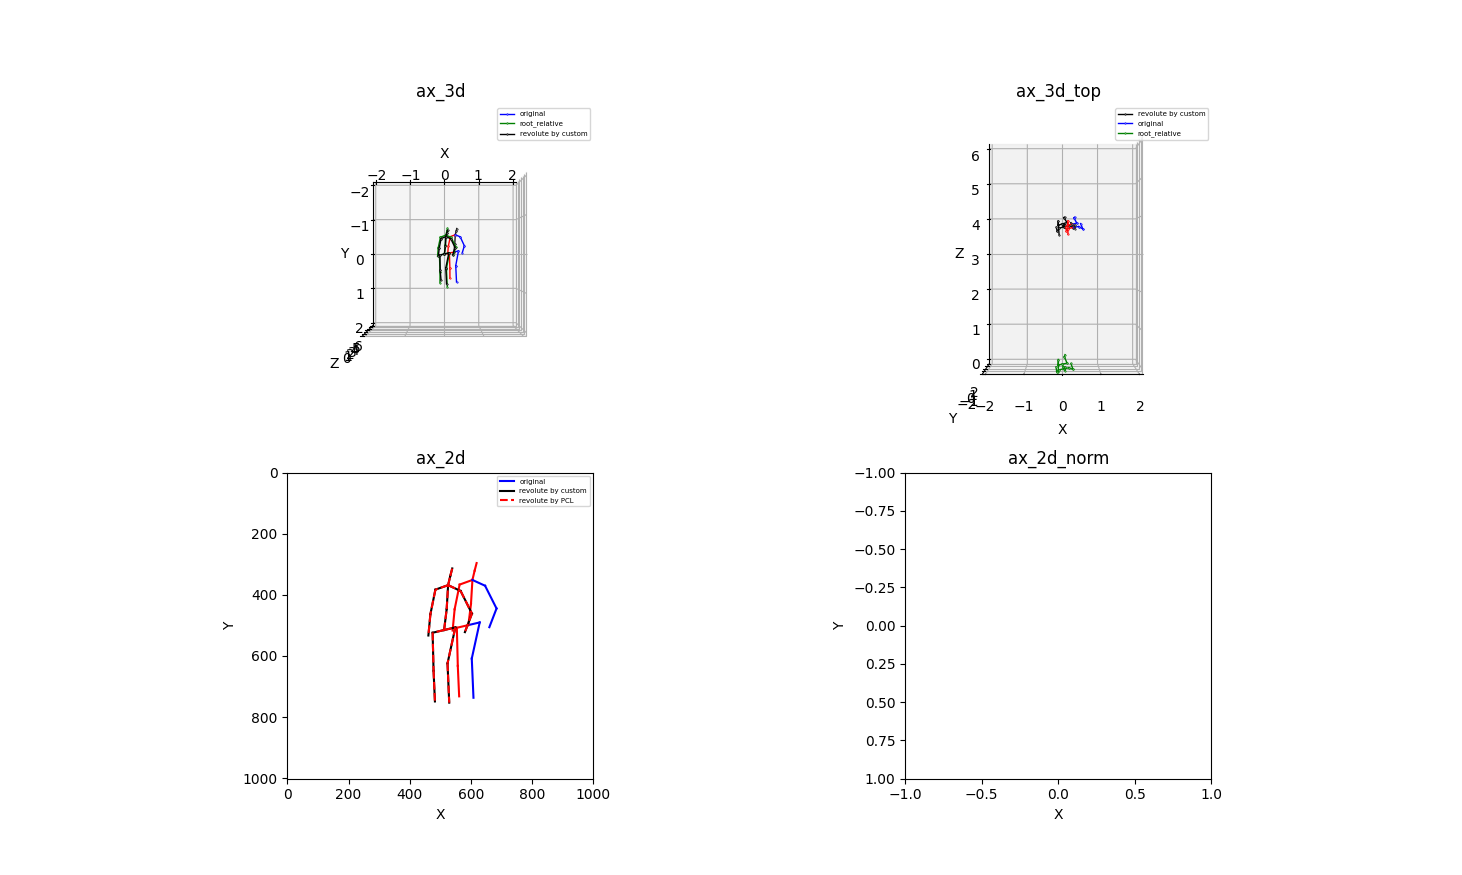

In [ ]:
# check original train data
frame_num = 1000
configs = {
    'ax_3d': {'type': '3d', 'loc': 221, 'mode': 'cam', 'zlim': [0, 6]},
    'ax_3d_top': {'type': '3d', 'loc': 222, 'mode': 'cam_top', 'zlim': [0, 6]},
    'ax_2d': {'type': '2d', 'loc': 223, 'W': W, 'H': H},
    'ax_2d_norm': {'type': '2d', 'loc': 224, 'normalize': True},
}
fig, axs = generate_axes(1, configs, fig_title='')
plot_pose_setting = [
    ('ax_3d', cam_3d,                               {'color': '', 'label': 'original'}),
    ('ax_3d', cam_3d_hat,                           {'color': 'g', 'label': 'root_relative'}),
    ('ax_3d', cam_3d_canonical_revolute,            {'color': 'k', 'label': 'revolute by custom'}),
    ('ax_3d_top', cam_3d_canonical_revolute,           {'color': 'k', 'label': 'revolute by custom'}),
    ('ax_3d_top', cam_3d,                               {'color': '', 'label': 'original'}),
    ('ax_3d_top', cam_3d_hat,                           {'color': 'g', 'label': 'root_relative'}),
    ('ax_2d', img_2d,                               {'color': '', 'label': 'original'}),
    ('ax_2d', img_2d_canonical_revolute,            {'color': 'k', 'label': 'revolute by custom'}),
    ('ax_2d', img_2d_rotated,                       {'color': 'r', 'linestyle': '--', 'label': 'revolute by PCL'}),
]
general_plot_func(axs, configs, plot_pose_setting, frame_num)
plt.show()

# Generate PCL dataset

In [3]:
data_type_list = ['source_list', 'cam_param', 'img_2d', 'img_2d_canonical_revolute', 'img_2d_canonical_pcl', 'cam_3d_canonical_pcl', 'cam_3d']
overwrite_list = []
dataset_name = 'h36m'
data_aug = default_data_aug.copy()
data = load_data_dict(dataset_name, data_type_list, overwrite_list, verbose=True, data_aug=data_aug)

[overwrite: False] ==> Loading H36M source_list...
[overwrite: False] ==> Loading H36M cam_param...
[overwrite: False] ==> Loading H36M img_2d...
[overwrite: False] ==> Loading H36M img_2d_canonical_revolute...
[overwrite: False] ==> Loading H36M img_2d_canonical_pcl...


100%|██████████| 836/836 [00:03<00:00, 229.39it/s]


[overwrite: False] ==> Loading H36M cam_3d_canonical_pcl...
[overwrite: False] ==> Loading H36M cam_3d...


In [ ]:
subject = 'S5'
action = 'Walking 1'
cam_id = '54138969'

cam_3d = data['cam_3d'][subject][action][cam_id].copy()
cam_3d_canonical_pcl = data['cam_3d_canonical_pcl'][subject][action][cam_id].copy()
assert (cam_3d - cam_3d_canonical_pcl).sum() == 0, (cam_3d - cam_3d_canonical_pcl).sum() # cam_3d_canonical_pcl should be the same as cam_3d (operation is done for pred 3D)

cam_param = data['cam_param'][subject][action][cam_id].copy()
W, H, K = cam_param['W'], cam_param['H'], cam_param['intrinsic']
img_2d = data['img_2d'][subject][action][cam_id].copy()
img_2d_canonical_revolute = data['img_2d_canonical_revolute'][subject][action][cam_id].copy()
img_2d_canonical_revolute_centered = img_2d_canonical_revolute.copy() - img_2d_canonical_revolute[:, 0:1, :] + np.array([W/2, H/2]).reshape(1, 2)
img_2d_pcl = data['img_2d_canonical_pcl'][subject][action][cam_id].copy() # genertate_pcl_img_2d(img_2d, cam_param)
img_2d_pcl_centered = img_2d_pcl.copy() - img_2d_pcl[:, 0:1, :] + np.array([W/2, H/2]).reshape(1, 2)

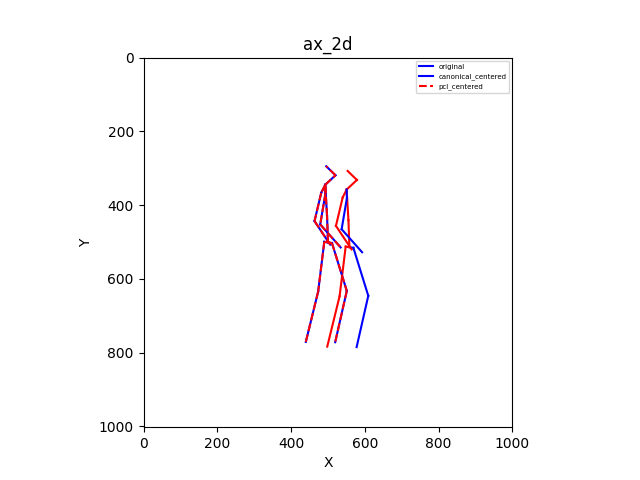

In [4]:
# check original train data
frame_num = 1500
configs = {
    'ax_2d': {'type': '2d', 'loc': 111, 'W': W, 'H': H},
}
fig, axs = generate_axes(1, configs, fig_title='')
plot_pose_setting = [
    ('ax_2d', img_2d,                               {'color': '', 'label': 'original'}),
    ('ax_2d', img_2d_canonical_revolute_centered,   {'color': 'b', 'label': 'canonical_centered'}),
    ('ax_2d', img_2d_pcl_centered,                  {'color': 'r', 'label': 'pcl_centered', 'linestyle': '--'}),
]
general_plot_func(axs, configs, plot_pose_setting, frame_num)
plt.show()

# H36M

In [2]:
data_type_list = ['source_list', 'cam_param', 'cam_3d', 'img_2d', 'cam_3d_canonical_same_z', 'img_2d_canonical_same_z']
overwrite_list = []
dataset_name = 'h36m'
data_aug = default_data_aug.copy()
data = load_data_dict(dataset_name, data_type_list, overwrite_list, verbose=True, data_aug=data_aug)

[overwrite: False] ==> Loading H36M source_list...
[overwrite: False] ==> Loading H36M cam_param...
[overwrite: False] ==> Loading H36M cam_3d...
[overwrite: False] ==> Loading H36M img_2d...
[overwrite: False] ==> Loading H36M cam_3d_canonical_same_z...
[overwrite: False] ==> Loading H36M img_2d_canonical_same_z...


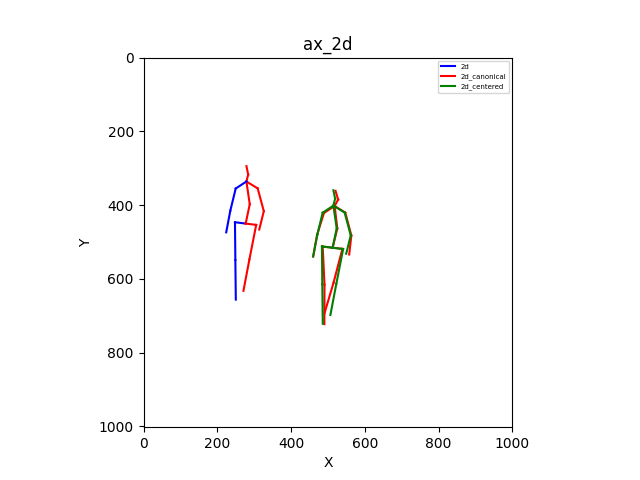

In [3]:
subject = 'S5'
action = 'Walking 1'
cam_id = '54138969'

cam_param = data['cam_param'][subject][action][cam_id].copy()
W, H, intrinsic = cam_param['W'], cam_param['H'], cam_param['intrinsic']
fx, fy, cx, cy = intrinsic[0, 0], intrinsic[1, 1], intrinsic[0, 2], intrinsic[1, 2]
cam_3d = data['cam_3d'][subject][action][cam_id].copy() #- np.array([1, 0, 3])
cam_3d_canonical = canonicalization_cam_3d(cam_3d, canonical_type='same_z')
img_2d = projection(cam_3d, intrinsic) # data['img_2d'][subject][action][cam_id].copy()
img_2d_canonical = projection(cam_3d_canonical, intrinsic) # data['img_2d_canonical_same_z'][subject][action][cam_id].copy()
img_2d_centered = img_2d.copy() - img_2d[:, 0:1] + np.array([cx, cy])

camera = Camera(origin=np.array([0, 0, 0]),
                calib_mat=intrinsic,
                cam_default_R=np.eye(3),
                IMAGE_HEIGHT=H,
                IMAGE_WIDTH=W,
                cam_name='cam_frame')

# check original train data
frame_num = 300
configs = {
    'ax_2d': {'type': '2d', 'loc': 111, 'W': W, 'H': H},
}
fig, axs = generate_axes(0, configs, fig_title='')
plot_pose_setting = [
    ('ax_2d', img_2d,           {'color': '', 'label': '2d'}),
    ('ax_2d', img_2d_canonical, {'color': 'r', 'label': '2d_canonical'}),
    ('ax_2d', img_2d_centered,  {'color': 'g', 'label': '2d_centered'}),
]
general_plot_func(axs, configs, plot_pose_setting, frame_num)
plt.show()

### canonical_revolute

In [247]:
dist = np.linalg.norm(cam_3d[:, 0], axis=1)
v_origin_to_pelvis = cam_3d[:, 0] / dist[:, None]
v_origin_to_revolute = np.array([0, 0, 1]).reshape(1, 3).repeat(len(cam_3d), axis=0)
assert v_origin_to_revolute.shape == v_origin_to_pelvis.shape, (v_origin_to_revolute.shape, v_origin_to_pelvis.shape)

rot_pelvis_to_revolute = batch_rotation_matrix_from_vectors(v_origin_to_pelvis, v_origin_to_revolute)
rot_revolute_to_pelvis = batch_rotation_matrix_from_vectors(v_origin_to_revolute, v_origin_to_pelvis)


K = intrinsic.copy()
K_inv = np.linalg.inv(K)
locations = img_2d[:, 0]
locations = np.hstack([locations, np.ones((locations.shape[0], 1))]) # to homogeneous coordinates
locations = locations @ K_inv.T

R_virt2reals = batch_virtualCameraRotationFromPosition(locations)
R_real2virts = np.linalg.inv(R_virt2reals)

cam_3d_hat = cam_3d.copy() - cam_3d[:, 0:1]
cam_3d_hat_rotated1 = np.einsum('ijk,ikl->ijl', cam_3d_hat.copy(), rot_pelvis_to_revolute)
cam_3d_hat_rotated2 = np.einsum('ijk,ikl->ijl', cam_3d_hat.copy(), R_virt2reals)
# cam_3d_canonical_revolute1 = cam_3d_hat_rotated1.copy()
# cam_3d_canonical_revolute1[:, :, 2] += dist[:, None]
cam_3d_canonical_revolute1 = np.einsum('ijk,ikl->ijl', cam_3d.copy(), rot_revolute_to_pelvis)
cam_3d_canonical_revolute2 = cam_3d_hat_rotated2.copy()
cam_3d_canonical_revolute2[:, :, 2] += dist[:, None]
img_2d_canonical_revolute = projection(cam_3d_canonical_revolute1, intrinsic)

norm_2d = img_2d.copy() # np.stack([img_2d, np.ones([img_2d.shape[0], img_2d.shape[1], 1])])
norm_2d = np.concatenate([norm_2d, np.ones((norm_2d.shape[0], norm_2d.shape[1], 1))], axis=-1)
norm_2d = norm_2d @ K_inv.T

norm_2d_rotated = np.einsum('ijk,ikl->ijl', norm_2d, R_virt2reals)
img_2d_rotated = projection(norm_2d_rotated, intrinsic)

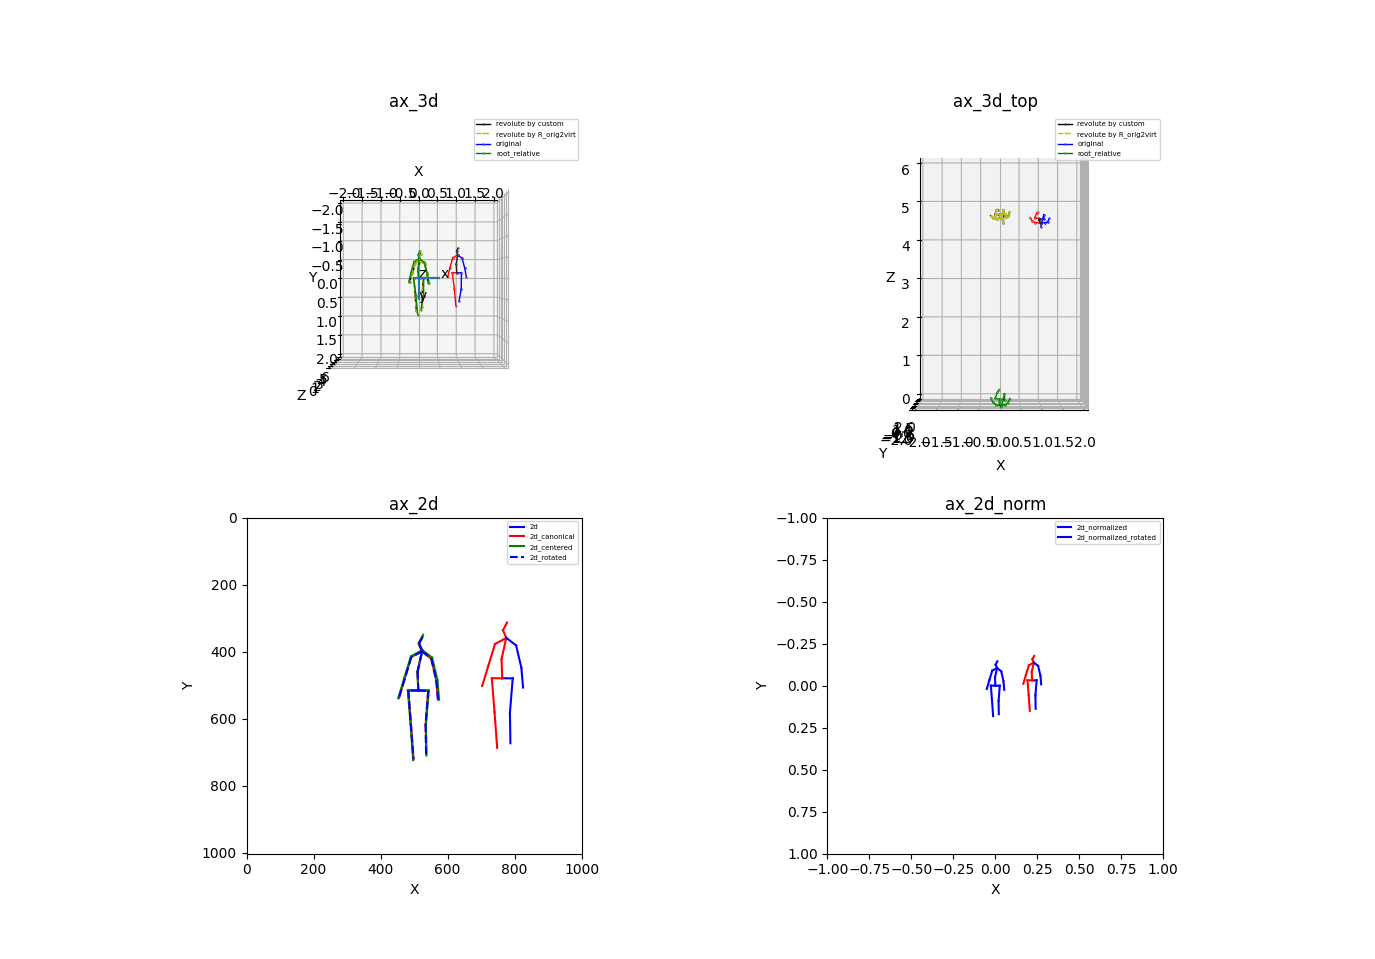

In [252]:
# check original train data
frame_num = 500
configs = {
    'ax_3d': {'type': '3d', 'loc': 221, 'mode': 'cam', 'zlim': [0, 6]},
    'ax_3d_top': {'type': '3d', 'loc': 222, 'mode': 'cam_top', 'zlim': [0, 6]},
    'ax_2d': {'type': '2d', 'loc': 223, 'W': W, 'H': H},
    'ax_2d_norm': {'type': '2d', 'loc': 224, 'normalize': True},
}
fig, axs = generate_axes(1, configs, fig_title='')
plot_pose_setting = [
    ('ax_3d', cam_3d_canonical_revolute1,           {'color': 'k', 'label': 'revolute by custom'}),
    ('ax_3d', cam_3d_canonical_revolute2,           {'color': 'y', 'linestyle': '--', 'linewidth': 0.1, 'label': 'revolute by R_orig2virt'}),
    ('ax_3d', cam_3d,                               {'color': '', 'label': 'original'}),
    ('ax_3d', cam_3d_hat,                           {'color': 'g', 'label': 'root_relative'}),
    ('ax_3d_top', cam_3d_canonical_revolute1,           {'color': 'k', 'label': 'revolute by custom'}),
    ('ax_3d_top', cam_3d_canonical_revolute2,           {'color': 'y', 'linestyle': '--', 'label': 'revolute by R_orig2virt'}),
    ('ax_3d_top', cam_3d,                               {'color': '', 'label': 'original'}),
    ('ax_3d_top', cam_3d_hat,                           {'color': 'g', 'label': 'root_relative'}),
    ('ax_2d', img_2d,                               {'color': '', 'label': '2d'}),
    ('ax_2d', img_2d_canonical_revolute,            {'color': 'r', 'label': '2d_canonical'}),
    ('ax_2d', img_2d_centered,                      {'color': 'g', 'label': '2d_centered'}),
    ('ax_2d_norm', norm_2d,                         {'color': '', 'label': '2d_normalized'}),
    ('ax_2d_norm', norm_2d_rotated,                 {'color': 'b', 'label': '2d_normalized_rotated'}),
    ('ax_2d', img_2d_rotated,                       {'color': 'b', 'linestyle': '--', 'label': '2d_rotated'}),
]
general_plot_func(axs, configs, plot_pose_setting, frame_num)
plt.sca(axs['ax_3d'])
camera.cam_frame.draw3d(show_name=False)
plt.show()

In [251]:
np.linalg.norm(img_2d_canonical - img_2d_canonical_revolute), np.linalg.norm(img_2d_centered - img_2d_canonical_revolute), np.linalg.norm(img_2d_canonical - img_2d_centered)

(1186.0948813684433, 468.0448357478669, 1240.8624140739103)

### Check torch function

In [7]:
checkpoint = 'MB_train_h36m_gt_cam_no_factor_input_from_canonical_pcl_input_centering_fix_orientation_pred_tr_s1_ts_s5678'
args, opts = get_opt_args_from_model_name(checkpoint, mode='best')
args.fix_orientation_gt = True
#model_pos, chk_filename, checkpoint = load_model(opts, args)

#subset = 'H36M-GT-CAM_NO_FACTOR'
#args.subset_list = [subset]
train_loader, test_loader, _, _, datareader = load_dataset(args, use_new_datareader=True)

configs/pose3d/MB_train_h36m_gt_cam_no_factor_input_from_canonical_pcl_input_centering_fix_orientation_pred_tr_s1_ts_s5678.yaml
True
Loading dataset...
H36M-GT-CAM_NO_FACTOR-INPUT_FROM_CANONICAL_PCL-TR_S1_TS_S5678
[overwrite: False] ==> Loading H36M source_list...
[overwrite: False] ==> Loading H36M cam_param...
[overwrite: False] ==> Loading H36M cam_3d...
[overwrite: False] ==> Loading H36M cam_3d_canonical_pcl...
[overwrite: False] ==> Loading H36M img_2d_canonical_pcl...


In [30]:
train_loader, test_loader, _, _, datareader = load_dataset(args, use_new_datareader=True)
args.mask = (args.mask_ratio > 0 and args.mask_T_ratio > 0)

with torch.no_grad():
    for batch_input, batch_gt in tqdm(train_loader): # batch_input: normalized joint_2d, batch_gt: normalized joint3d_image
        batch_size = len(batch_input)

        batch_v_origin_to_pelvis = batch_gt[:, :, 0]
        batch_v_origin_to_principle = torch.tensor([0, 0, 1], device=batch_gt.device).reshape(1, 1, 3).repeat(batch_gt.shape[0], batch_gt.shape[1], 1).float().to(batch_gt.device)
        assert batch_v_origin_to_principle.shape == batch_v_origin_to_pelvis.shape, (batch_v_origin_to_principle.shape, batch_v_origin_to_pelvis.shape)
        batch_rot_principle_to_pelvis = batch_rotation_matrix_from_vectors_torch(batch_v_origin_to_principle, batch_v_origin_to_pelvis)
        batch_rot_principle_to_pelvis_inv = batch_inverse_rotation_matrices(batch_rot_principle_to_pelvis)

        # # preprocessing
        batch_input, batch_gt, batch_gt_torso, batch_gt_limb, conf = preprocess_train(args, batch_input, batch_gt, has_3d=True, has_gt=True)
        batch_gt_rotated = torch.einsum('bfij,bfjk->bfik', batch_gt, batch_rot_principle_to_pelvis_inv.to(batch_gt.device)) # rotate back the predicted 3D poses from canonical to the orginal pelvis position
        break

Loading dataset...
H36M-GT-CAM_NO_FACTOR-INPUT_FROM_CANONICAL_PCL-TR_S1_TS_S5678
[overwrite: False] ==> Loading H36M source_list...
[overwrite: False] ==> Loading H36M cam_param...
[overwrite: False] ==> Loading H36M cam_3d...
[overwrite: False] ==> Loading H36M cam_3d_canonical_pcl...
[overwrite: False] ==> Loading H36M img_2d_canonical_pcl...


  0%|          | 0/173 [00:01<?, ?it/s]


In [47]:
args.fix_orientation_gt, args.fix_orientation_pred 

(True, True)

In [67]:
test = {'test': 1, 'test2': 2}
print(*test, sep='\n')

test
test2


  0%|          | 0/323 [00:00<?, ?it/s]

  0%|          | 0/323 [00:00<?, ?it/s]


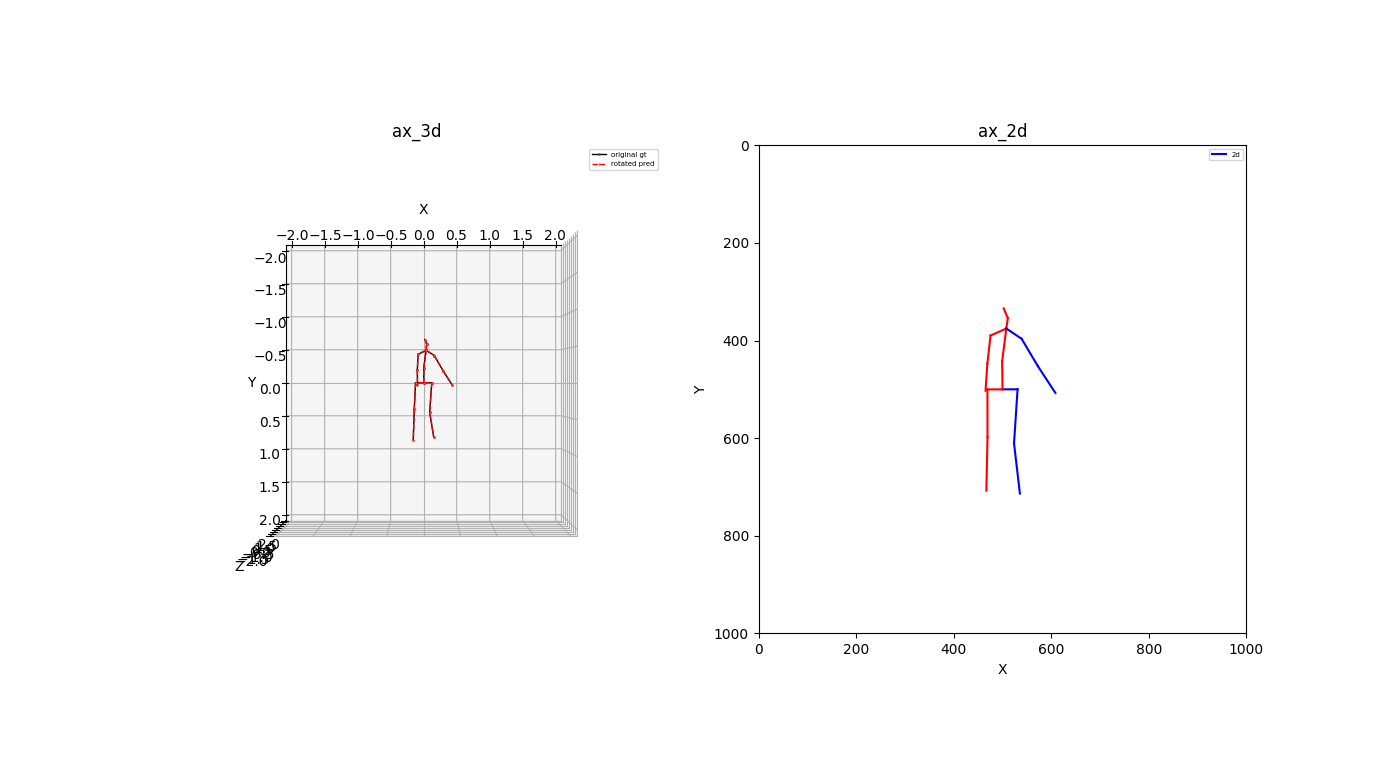

In [65]:
with torch.no_grad():
    for batch_input, batch_gt in tqdm(test_loader): # batch_input: normalized joint_2d, batch_gt: normalized joint3d_image
        batch_size = len(batch_input)
        # original 3D poses
        batch_gt_original = batch_gt.clone().detach()
        # rotation matrix from principal axis to pelvis
        batch_v_origin_to_pelvis = batch_gt_original[:, :, 0]
        batch_v_origin_to_principle = torch.tensor([0, 0, 1], device=batch_gt.device).reshape(1, 1, 3).repeat(batch_gt.shape[0], batch_gt.shape[1], 1).float().to(batch_gt.device)
        assert batch_v_origin_to_principle.shape == batch_v_origin_to_pelvis.shape, (batch_v_origin_to_principle.shape, batch_v_origin_to_pelvis.shape)
        batch_rot_principle_to_pelvis = batch_rotation_matrix_from_vectors_torch(batch_v_origin_to_principle, batch_v_origin_to_pelvis)
        batch_rot_principle_to_pelvis_inv = batch_inverse_rotation_matrices(batch_rot_principle_to_pelvis)
        # preprocessing
        args.rootrel = True
        batch_input, batch_gt, batch_gt_torso, batch_gt_limb_pos = preprocess_eval(args, batch_input, batch_gt)
        # rotate back the predicted 3D poses from
        batch_gt_rotated = torch.einsum('bfij,bfjk->bfik', batch_gt, batch_rot_principle_to_pelvis_inv.to(batch_gt.device))
        break

batch_num, frame_num = 15, 200
pose2d_norm = batch_input[batch_num][frame_num].cpu().numpy()
pose2d = denormalize_input(pose2d_norm, 1000, 1000)
pose3d_original = batch_gt_original[batch_num][frame_num].cpu().numpy()
pose3d_original_hat = pose3d_original.copy() - pose3d_original[0:1]
pose3d_pred = batch_gt[batch_num][frame_num].cpu().numpy()
pose3d_rotated = batch_gt_rotated[batch_num][frame_num].cpu().numpy()

frame_num = 0
configs = {
    'ax_3d': {'type': '3d', 'loc': 121, 'mode': 'cam'},
    'ax_2d': {'type': '2d', 'loc': 122, 'W': 1000, 'H': 1000},
}
fig, axs = generate_axes(2, configs, fig_title='')
plot_pose_setting = [
    ('ax_3d', pose3d_original_hat[None],           {'color': 'k', 'label': 'original gt'}),
    #('ax_3d', pose3d_pred[None],           {'color': 'b', 'label': 'pred'}),
    ('ax_3d', pose3d_rotated[None],   {'color': 'r', 'label': 'rotated pred', 'linestyle': '--'}),
    ('ax_2d', pose2d[None],           {'color': '', 'label': '2d'}),
]
general_plot_func(axs, configs, plot_pose_setting, frame_num)
plt.show()

In [56]:
pose3d_pred

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.18117206e-01, -3.52721545e-04,  1.68509483e-02],
       [ 8.99522379e-02,  4.26701128e-01,  3.29990387e-02],
       [ 1.27253637e-01,  7.72514999e-01, -2.40457058e-01],
       [-1.18116386e-01,  3.52739764e-04, -1.68504715e-02],
       [-1.22672886e-01,  3.90228719e-01,  1.60363674e-01],
       [-1.33876979e-01,  8.30865145e-01,  1.98715687e-01],
       [-2.72169616e-03, -2.18293324e-01, -5.15661240e-02],
       [ 2.95800958e-02, -4.69656289e-01, -6.93864822e-02],
       [ 4.20516580e-02, -5.59103489e-01,  5.18035889e-03],
       [ 1.00273332e-02, -6.22284889e-01, -8.54134560e-02],
       [-9.08875242e-02, -4.10555750e-01, -1.19098186e-01],
       [-1.11678347e-01, -1.89689219e-01, -2.63288498e-01],
       [-1.20821126e-01,  9.62517317e-03, -4.11619902e-01],
       [ 1.48035452e-01, -3.92235875e-01, -4.81410027e-02],
       [ 2.68012464e-01, -1.75715312e-01, -1.41569614e-01],
       [ 3.94673944e-01,  2.77126804e-02

In [9]:
with torch.no_grad():
    for batch_input, batch_gt in tqdm(test_loader): # batch_input: normalized joint_2d, batch_gt: normalized joint3d_image
        batch_size = len(batch_input)
        # preprocessing
        batch_input, batch_gt, batch_gt_torso, batch_gt_limb_pos = preprocess_eval(args, batch_input, batch_gt)
        break

  0%|          | 0/323 [00:00<?, ?it/s]

  0%|          | 0/323 [00:01<?, ?it/s]


In [7]:
batch_v_origin_to_pelvis = batch_gt[:, :, 0]
batch_v_origin_to_revolute = torch.tensor([0, 0, 1], device=batch_gt.device).reshape(1, 1, 3).repeat(batch_gt.shape[0], batch_gt.shape[1], 1).float()
assert batch_v_origin_to_revolute.shape == batch_v_origin_to_pelvis.shape, (batch_v_origin_to_revolute.shape, batch_v_origin_to_pelvis.shape)

batch_rot_pelvis_to_revolute = batch_rotation_matrix_from_vectors_torch(batch_v_origin_to_pelvis, batch_v_origin_to_revolute)
batch_rot_revolute_to_pelvis = batch_inverse_rotation_matrices(batch_rot_pelvis_to_revolute) # batch_rotation_matrix_from_vectors_torch(batch_v_origin_to_revolute, batch_v_origin_to_pelvis)

batch_gt_rotated = torch.einsum('bfij,bfjk->bfik', batch_gt, batch_rot_revolute_to_pelvis)

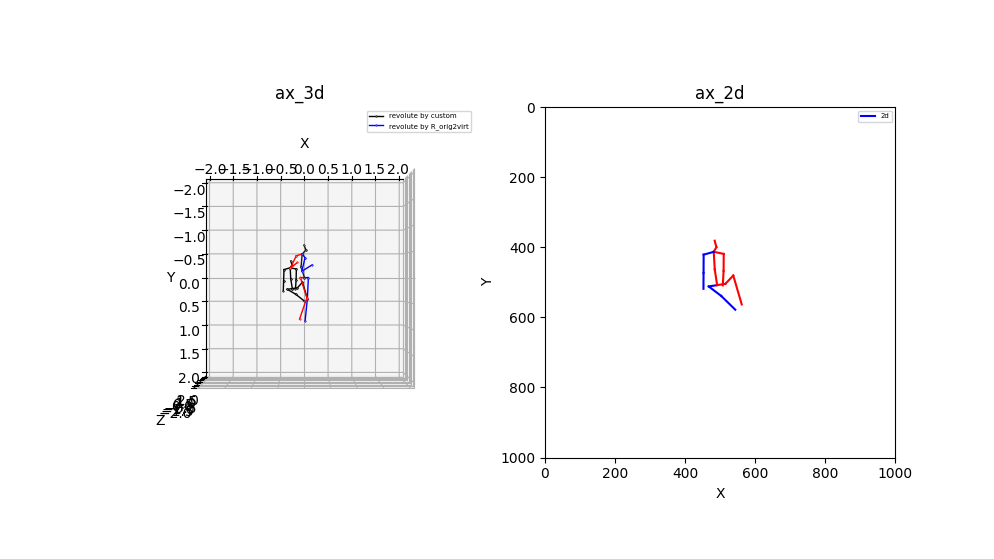

In [21]:
batch_num, frame_num = 2, 150
pose2d_norm = batch_input[batch_num][frame_num].cpu().numpy()
pose2d = denormalize_input(pose2d_norm, 1000, 1000)
pose3d = batch_gt[batch_num][frame_num].cpu().numpy()
pose3d_rotated = batch_gt_rotated[batch_num][frame_num].cpu().numpy()

frame_num = 0
configs = {
    'ax_3d': {'type': '3d', 'loc': 121, 'mode': 'cam'},
    'ax_2d': {'type': '2d', 'loc': 122, 'W': 1000, 'H': 1000},
}
fig, axs = generate_axes(2, configs, fig_title='')
plot_pose_setting = [
    ('ax_3d', pose3d[None],           {'color': 'k', 'label': 'revolute by custom'}),
    ('ax_3d', pose3d_rotated[None],   {'color': '', 'label': 'revolute by R_orig2virt'}),
    ('ax_2d', pose2d[None],           {'color': '', 'label': '2d'}),
]
general_plot_func(axs, configs, plot_pose_setting, frame_num)
plt.show()

### PCL

In [ ]:
def generate_gt_scales_from2d(pose2d):
    max_x = pose2d[:, 0].max()
    min_x = pose2d[:, 0].min()
    max_y = pose2d[:, 1].max()
    min_y = pose2d[:, 1].min()
    scale_x = max_x - min_x
    scale_y = max_y - min_y
    return np.array([scale_x, scale_y])

def virtualCameraRotationFromPosition(position):
    x, y, z = position[0], position[1], position[2]
    n1x = np.sqrt(1 + x ** 2)
    d1x = 1 / n1x
    d1xy = 1 / np.sqrt(1 + x ** 2 + y ** 2)
    d1xy1x = 1 / np.sqrt((1 + x ** 2 + y ** 2) * (1 + x ** 2))
    R_virt2orig = np.array([d1x, -x * y * d1xy1x, x * d1xy,
                               0*x,      n1x * d1xy, y * d1xy,
                          -x * d1x,     -y * d1xy1x, 1 * d1xy]).reshape([3, 3])
    return R_virt2orig

In [ ]:
pose3d = cam_3d[frame_num].copy()
pelvis3d = pose3d[0]

K = intrinsic.copy()
hm_coord_2d = K.dot(pelvis3d)
location = hm_coord_2d/hm_coord_2d[2] # = img_2d[frame_num][0]

pose2d = img_2d[frame_num].copy()
pelvis2d = pose2d[0]
scale = generate_gt_scales_from2d(pose2d)

In [48]:
location[:2] - img_2d[frame_num][0]

array([0., 0.])

In [134]:
location, scale

(array([276.80450812, 449.96890865,   1.        ]),
 array([101.90125827, 361.89848708]))

In [135]:
pelvis2d

array([276.80450812, 449.96890865])

In [136]:
K_inv = np.linalg.inv(K)
p_position = K_inv @ location # backprojected point p
print(p_position)
R_virt2orig = virtualCameraRotationFromPosition(p_position)
R_virt2orig

[-0.20587496 -0.05725097  1.        ]


array([[ 0.97945847, -0.01128955, -0.20132969],
       [-0.        ,  0.9984315 , -0.055987  ],
       [ 0.20164597,  0.05483694,  0.97792219]])

In [137]:
p_length = np.linalg.norm(p_position)
focal_length_factor = p_length
sx = 1.0 / np.sqrt(p_position[0]**2+p_position[2]**2)  # this is cos(phi)
sy = np.sqrt(p_position[0]**2+1) / np.sqrt(p_position[0]**2+p_position[1]**2 + 1)  # this is cos(theta)
bbox_size_img = scale * np.array([sx,sy])
bbox_size_img

array([ 99.80805093, 361.33084861])

In [138]:
max_width = bbox_size_img.max()
bbox_size_img = np.array([max_width, max_width])

In [139]:
f_orig = np.array([K[0,0], K[1,1]])
f_compensated = focal_length_factor * f_orig / bbox_size_img

K_virt = np.zeros([3,3])
K_virt[2,2] = 1
# Note, in unit image coordinates ranging from 0..1
K_virt[ 0, 0] = f_compensated[0]
K_virt[ 1, 1] = f_compensated[1]
K_virt[:2, 2] = 0.5

In [140]:
K_virt_inv = np.linalg.inv(K_virt)
P_virt2orig = K @ R_virt2orig @ K_virt_inv
R_orig2virt = np.linalg.inv(R_virt2orig)
P_orig2virt = np.linalg.inv(P_virt2orig)

In [141]:
canonical_2d_pose = np.hstack([pose2d, np.ones((pose2d.shape[0], 1))])
PCL_canonical_2d_pose = (P_orig2virt @ canonical_2d_pose.T).T
virt_2d_pose = PCL_canonical_2d_pose.copy() / PCL_canonical_2d_pose[:, 2:3]
virt_2d_pose_hat = virt_2d_pose.copy() - virt_2d_pose[0]
virt_2d_pose_hat_denorm = virt_2d_pose_hat*scale[1]
virt_2d_pose_denorm = virt_2d_pose_hat_denorm + [pose2d[0,0], pose2d[0,1], 1]

In [142]:
virt_2d_pose_denorm

array([[276.80450812, 449.96890865,   1.        ],
       [248.50724616, 446.70212966,   1.        ],
       [249.35748746, 548.89790638,   1.        ],
       [250.44560359, 657.48349522,   1.        ],
       [304.90807653, 453.21332653,   1.        ],
       [286.76046624, 547.88782669,   1.        ],
       [270.82200221, 633.78860373,   1.        ],
       [287.66711265, 397.39556108,   1.        ],
       [278.79288789, 336.43441968,   1.        ],
       [283.42079348, 317.70741031,   1.        ],
       [278.87376036, 295.26247203,   1.        ],
       [308.71491179, 354.01192908,   1.        ],
       [325.36427899, 415.54162807,   1.        ],
       [313.1747022 , 465.80171853,   1.        ],
       [250.53051175, 356.16551469,   1.        ],
       [236.26586568, 416.0210131 ,   1.        ],
       [225.47431451, 474.10133243,   1.        ]])

In [143]:
# Create a batch of virt_2d_pose with batch size 1000
batch_size = img_2d.shape[0]
virt_2d_pose_denorm_batch = np.tile(virt_2d_pose_denorm, (batch_size, 1, 1))
virt_2d_pose_denorm_batch.shape

(3000, 17, 3)

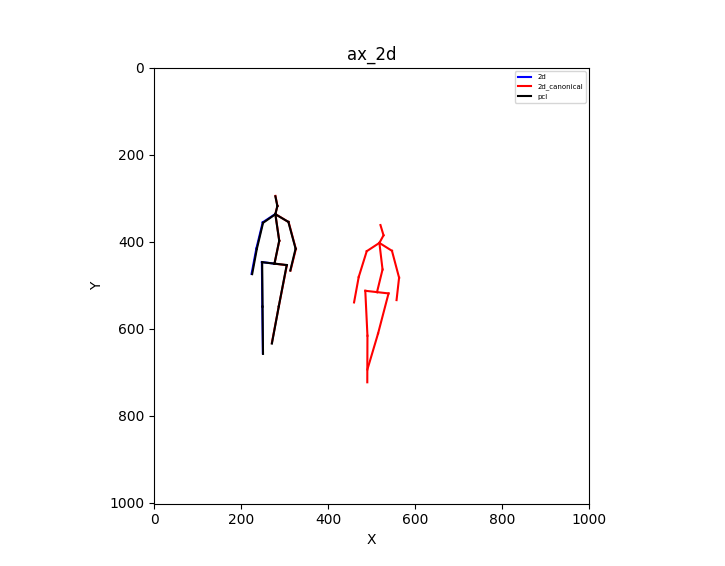

In [145]:
# check original train data
frame_num = 300
configs = {
    'ax_2d': {'type': '2d', 'loc': 111, 'W': W, 'H': H},
}
fig, axs = generate_axes(0, configs, fig_title='')
plot_pose_setting = [
    ('ax_2d', img_2d,           {'color': '', 'label': '2d'}),
    ('ax_2d', img_2d_canonical, {'color': 'r', 'label': '2d_canonical'}),
    ('ax_2d', virt_2d_pose_denorm_batch, {'color': 'k', 'label': 'pcl'}),
]
general_plot_func(axs, configs, plot_pose_setting, frame_num)
plt.show()

In [123]:
original_pose2d = img_2d[frame_num].copy()
canonical_pose2d = img_2d_canonical[frame_num].copy()
virt_pose2d = virt_2d_pose_denorm_batch[frame_num].copy()

original_pose2d_hat = original_pose2d - original_pose2d[0]
canonical_pose2d_hat = canonical_pose2d - canonical_pose2d[0]
virt_pose2d_hat = virt_pose2d - virt_pose2d[0]

In [125]:
original_pose2d_hat - virt_pose2d_hat[:, :2]

array([[ 0.00000000e+00,  0.00000000e+00],
       [ 5.08945944e-01, -9.01045954e-02],
       [ 1.96727371e-01,  4.55465800e-02],
       [ 4.57442168e-02, -6.02019849e-01],
       [-2.00947708e-01,  6.12344054e-02],
       [-1.45680675e-01, -6.58002711e-01],
       [ 1.19666986e-02, -2.10780958e+00],
       [-5.76354819e-02,  2.04343266e-03],
       [ 4.67883815e-02, -3.29749221e-01],
       [ 3.88171772e-02, -4.24594247e-01],
       [ 9.51651215e-02, -6.40097350e-01],
       [-2.60407271e-01,  4.21533833e-01],
       [-1.95747762e-01,  4.50814599e-01],
       [-1.83203960e-01,  6.75160721e-02],
       [ 6.67072590e-01, -8.44244319e-01],
       [ 1.18983846e+00, -4.81859839e-01],
       [ 8.24018940e-01, -6.99378610e-02]])

# 3DHP

In [4]:
data_type_list = ['source_list', 'cam_param', 'cam_3d', 'img_2d', 'cam_3d_canonical_same_z', 'img_2d_canonical_same_z']
overwrite_list = []
dataset_name = '3dhp'
data_aug = default_data_aug.copy()
data = load_data_dict(dataset_name, data_type_list, overwrite_list, verbose=True, data_aug=data_aug)

[overwrite: False] ==> Loading 3DHP source_list...
[overwrite: False] ==> Loading 3DHP cam_param...
[overwrite: False] ==> Loading 3DHP cam_3d...
[overwrite: False] ==> Loading 3DHP img_2d...
[overwrite: False] ==> Loading 3DHP cam_3d_canonical_same_z...
[overwrite: False] ==> Loading 3DHP img_2d_canonical_same_z...


In [5]:
data['source_list'][0]

'S1_cam0_Seq1'

In [6]:
split_source_name(data['source_list'][-1], '3dhp')

('TS6', None, None)

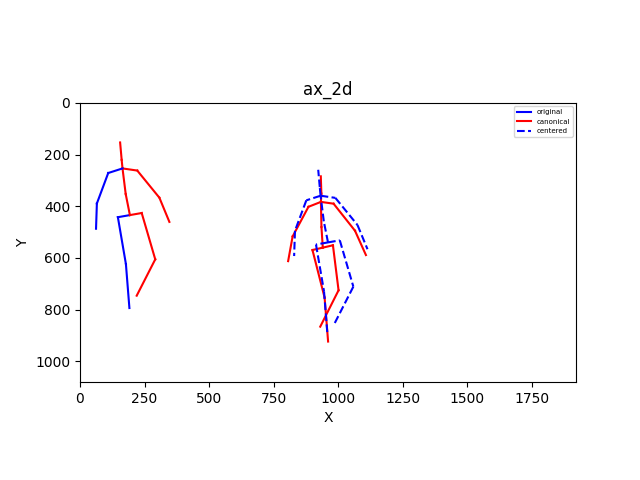

In [11]:
subject, cam_id, seq = split_source_name(data['source_list'][-1], '3dhp')

cam_param = data['cam_param'][subject][seq][cam_id].copy()
W, H, intrinsic = cam_param['W'], cam_param['H'], cam_param['intrinsic']
fx, fy, cx, cy = intrinsic[0, 0], intrinsic[1, 1], intrinsic[0, 2], intrinsic[1, 2]
cam_3d = data['cam_3d'][subject][seq][cam_id].copy() #+ np.array([4, 0, -2])
cam_3d_hat = cam_3d.copy() - cam_3d[:, 0:1]

# Rotate cam_3d around the y-axis by 45 degrees
theta = np.radians(45)
rotation_matrix_y = Rotation.from_rotvec([0, theta, 0]).as_matrix()
#cam_3d = np.einsum('ijk,kl->ijl', cam_3d_hat, rotation_matrix_y.T) + cam_3d[:, 0:1]

cam_3d_canonical = canonicalization_cam_3d(cam_3d, canonical_type='same_z')
img_2d = projection(cam_3d, intrinsic)
img_2d_canonical = projection(cam_3d_canonical, intrinsic)
img_2d_centered = img_2d.copy() - img_2d[:, 0:1] + np.array([W/2, H/2])

camera = Camera(origin=np.array([0, 0, 0]),
                calib_mat=intrinsic,
                cam_default_R=np.eye(3),
                IMAGE_HEIGHT=H,
                IMAGE_WIDTH=W,
                cam_name='cam_frame')

# check original train data
frame_num = 0
configs = {
    'ax_2d': {'type': '2d', 'loc': 111, 'W': W, 'H': H},
}
fig, axs = generate_axes(0, configs, fig_title='')
plot_pose_setting = [
    ('ax_2d', img_2d,           {'color': '', 'label': 'original'}),
    ('ax_2d', img_2d_canonical, {'color': 'r', 'label': 'canonical'}),
    ('ax_2d', img_2d_centered,  {'color': 'b', 'linestyle': '--', 'label': 'centered'}),
]
general_plot_func(axs, configs, plot_pose_setting, frame_num)
plt.show()

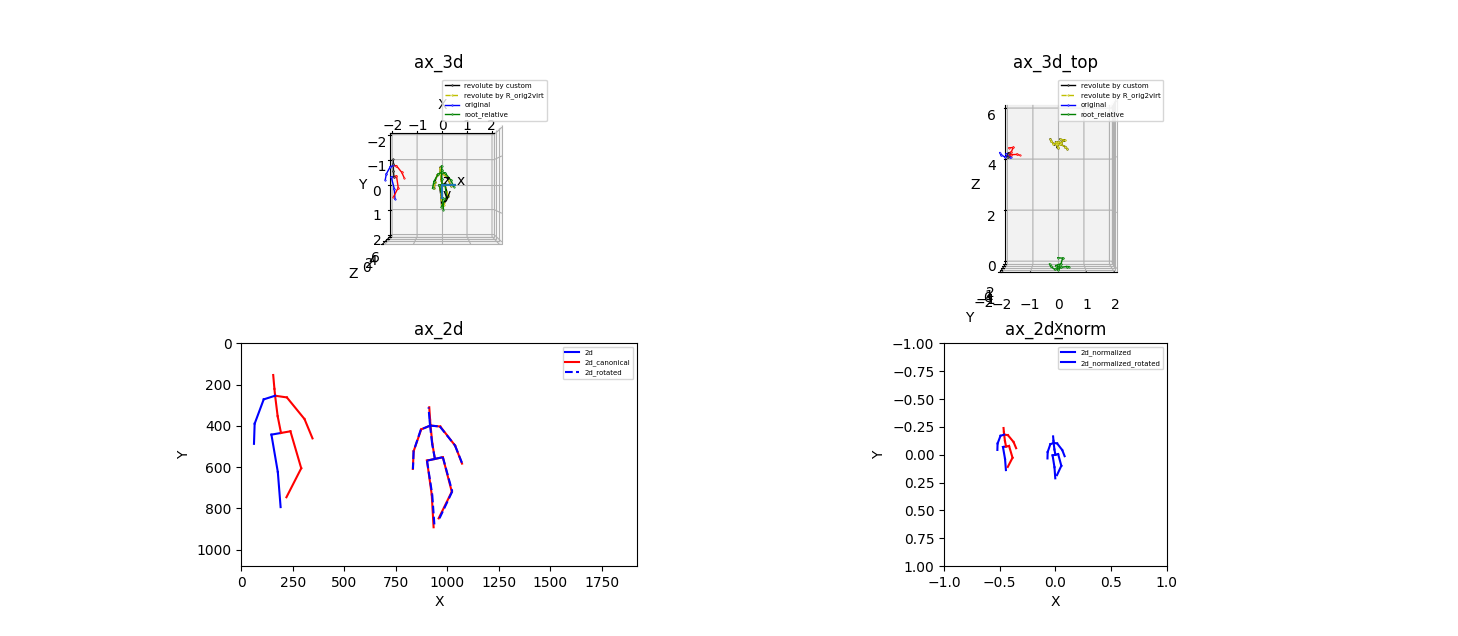

In [34]:
joint_id = get_h36m_keypoint_index('pelvis')

dist = np.linalg.norm(cam_3d[:, joint_id], axis=1)
v_origin_to_joint = cam_3d[:, joint_id] / dist[:, None]
v_origin_to_revolute = np.array([0, 0, 1]).reshape(1, 3).repeat(len(cam_3d), axis=0)
assert v_origin_to_revolute.shape == v_origin_to_joint.shape, (v_origin_to_revolute.shape, v_origin_to_joint.shape)

rot_joint_to_revolute = batch_rotation_matrix_from_vectors(v_origin_to_joint, v_origin_to_revolute)
rot_revolute_to_joint = batch_rotation_matrix_from_vectors(v_origin_to_revolute, v_origin_to_joint)


K = intrinsic.copy()
K_inv = np.linalg.inv(K)
locations = img_2d[:, joint_id]
locations = np.hstack([locations, np.ones((locations.shape[0], 1))]) # to homogeneous coordinates
locations = locations @ K_inv.T

R_virt2reals = batch_virtualCameraRotationFromPosition(locations)
R_real2virts = np.linalg.inv(R_virt2reals)

cam_3d_hat = cam_3d.copy() - cam_3d[:, joint_id:joint_id+1]
cam_3d_hat_rotated1 = np.einsum('ijk,ikl->ijl', cam_3d_hat.copy(), rot_joint_to_revolute)
cam_3d_hat_rotated2 = np.einsum('ijk,ikl->ijl', cam_3d_hat.copy(), R_virt2reals)
# cam_3d_canonical_revolute1 = cam_3d_hat_rotated1.copy()
# cam_3d_canonical_revolute1[:, :, 2] += dist[:, None]
cam_3d_canonical_revolute1 = np.einsum('ijk,ikl->ijl', cam_3d.copy(), rot_revolute_to_joint)
cam_3d_canonical_revolute2 = cam_3d_hat_rotated2.copy()
cam_3d_canonical_revolute2[:, :, 2] += dist[:, None]
img_2d_canonical_revolute = projection(cam_3d_canonical_revolute1, intrinsic)

norm_2d = img_2d.copy() # np.stack([img_2d, np.ones([img_2d.shape[0], img_2d.shape[1], 1])])
norm_2d = np.concatenate([norm_2d, np.ones((norm_2d.shape[0], norm_2d.shape[1], 1))], axis=-1)
norm_2d = norm_2d @ K_inv.T

norm_2d_rotated = np.einsum('ijk,ikl->ijl', norm_2d, R_virt2reals)
img_2d_rotated = projection(norm_2d_rotated, intrinsic)

# check original train data
configs = {
    'ax_3d': {'type': '3d', 'loc': 221, 'mode': 'cam', 'zlim': [0, 6]},
    'ax_3d_top': {'type': '3d', 'loc': 222, 'mode': 'cam_top', 'zlim': [0, 6]},
    'ax_2d': {'type': '2d', 'loc': 223, 'W': W, 'H': H},
    'ax_2d_norm': {'type': '2d', 'loc': 224, 'normalize': True},
}
fig, axs = generate_axes(1, configs, fig_title='')
plot_pose_setting = [
    ('ax_3d', cam_3d_canonical_revolute1,           {'color': 'k', 'label': 'revolute by custom'}),
    ('ax_3d', cam_3d_canonical_revolute2,           {'color': 'y', 'linestyle': '--', 'linewidth': 0.1, 'label': 'revolute by R_orig2virt'}),
    ('ax_3d', cam_3d,                               {'color': '', 'label': 'original'}),
    ('ax_3d', cam_3d_hat,                           {'color': 'g', 'label': 'root_relative'}),
    ('ax_3d_top', cam_3d_canonical_revolute1,           {'color': 'k', 'label': 'revolute by custom'}),
    ('ax_3d_top', cam_3d_canonical_revolute2,           {'color': 'y', 'linestyle': '--', 'label': 'revolute by R_orig2virt'}),
    ('ax_3d_top', cam_3d,                               {'color': '', 'label': 'original'}),
    ('ax_3d_top', cam_3d_hat,                           {'color': 'g', 'label': 'root_relative'}),
    ('ax_2d', img_2d,                               {'color': '', 'label': '2d'}),
    ('ax_2d', img_2d_canonical_revolute,            {'color': 'r', 'label': '2d_canonical'}),
    #('ax_2d', img_2d_centered,                      {'color': 'g', 'label': '2d_centered'}),
    ('ax_2d_norm', norm_2d,                         {'color': '', 'label': '2d_normalized'}),
    ('ax_2d_norm', norm_2d_rotated,                 {'color': 'b', 'label': '2d_normalized_rotated'}),
    ('ax_2d', img_2d_rotated,                       {'color': 'b', 'linestyle': '--', 'label': '2d_rotated'}),
]
general_plot_func(axs, configs, plot_pose_setting, frame_num)
plt.sca(axs['ax_3d'])
camera.cam_frame.draw3d(show_name=False)
plt.show()

# Individual joint error with changing target center p

In [30]:
l_wrist_id = get_h36m_keypoint_index('l_wrist')
l_elbow_id = get_h36m_keypoint_index('l_elbow')
l_shoulder_id = get_h36m_keypoint_index('l_shoulder')
r_wrist_id = get_h36m_keypoint_index('r_wrist')
r_elbow_id = get_h36m_keypoint_index('r_elbow')
r_shoulder_id = get_h36m_keypoint_index('r_shoulder')
l_arm_id = [l_shoulder_id, l_elbow_id, l_wrist_id]
r_arm_id = [r_shoulder_id, r_elbow_id, r_wrist_id]

l_ankle_id = get_h36m_keypoint_index('l_ankle')
l_knee_id = get_h36m_keypoint_index('l_knee')
l_hip_id = get_h36m_keypoint_index('l_hip')
r_ankle_id = get_h36m_keypoint_index('r_ankle')
r_knee_id = get_h36m_keypoint_index('r_knee')
r_hip_id = get_h36m_keypoint_index('r_hip')
l_leg_id = [l_hip_id, l_knee_id, l_ankle_id]
r_leg_id = [r_hip_id, r_knee_id, r_ankle_id]

In [39]:
from hpe_library.my_utils.test_utils import h36m_keypoints
h36m_keypoints

{0: 'Pelvis',
 1: 'R_Hip',
 2: 'R_Knee',
 3: 'R_Ankle',
 4: 'L_Hip',
 5: 'L_Knee',
 6: 'L_Ankle',
 7: 'Torso',
 8: 'Neck',
 9: 'Nose',
 10: 'Head',
 11: 'L_Shoulder',
 12: 'L_Elbow',
 13: 'L_Wrist',
 14: 'R_Shoulder',
 15: 'R_Elbow',
 16: 'R_Wrist'}

Pelvis
R_Hip
R_Knee
R_Ankle
L_Hip
L_Knee
L_Ankle
Torso
Neck
Nose
Head
L_Shoulder
L_Elbow
L_Wrist
R_Shoulder
R_Elbow
R_Wrist


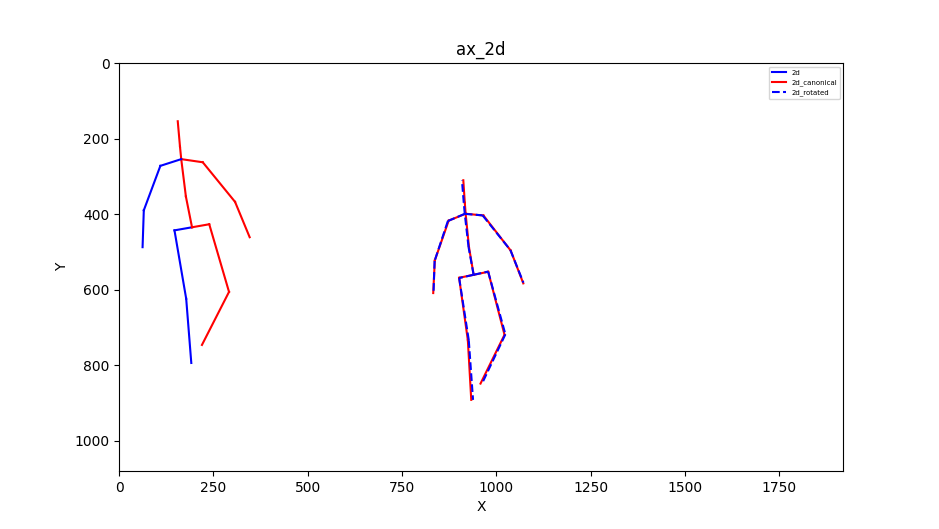

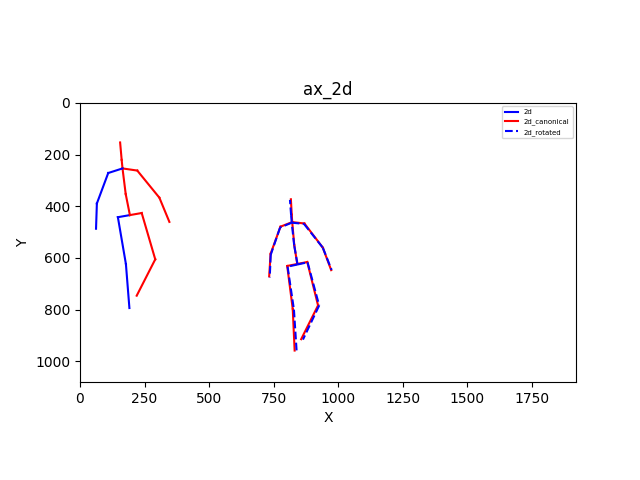

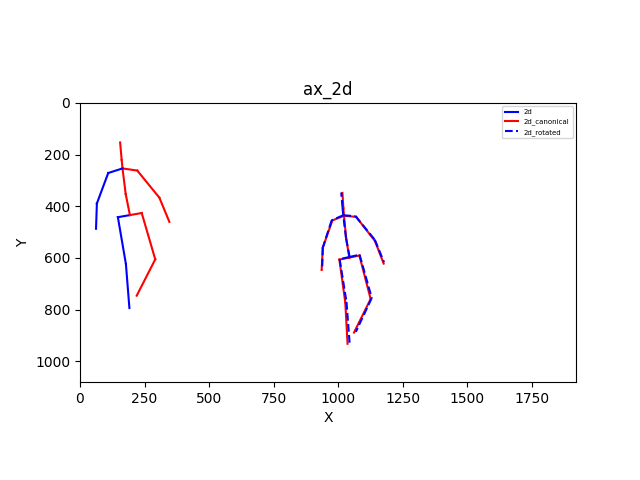

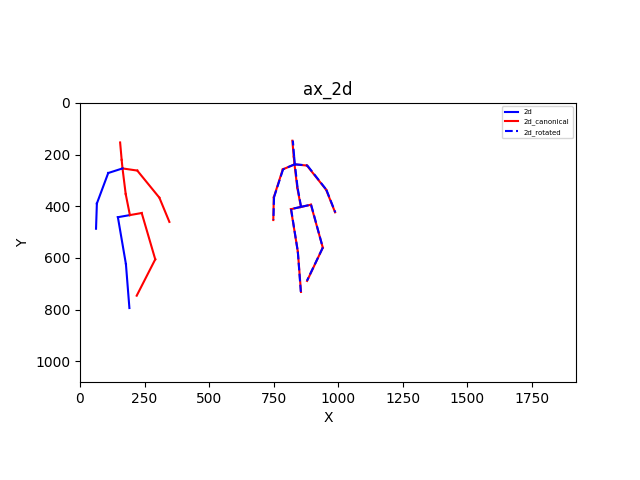

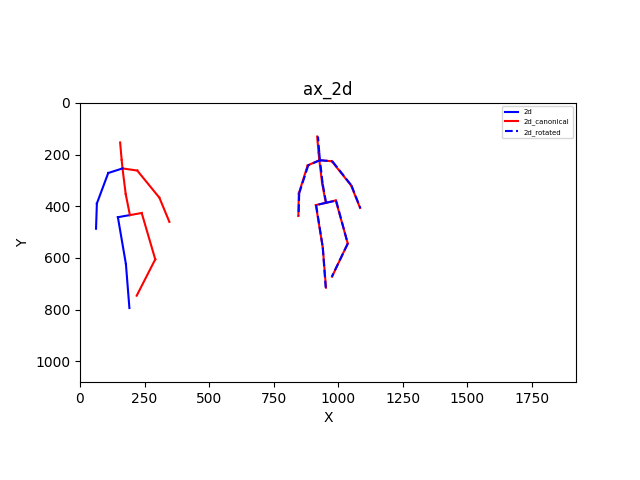

target joint,Pelvis,R_Hip,R_Knee,R_Ankle,L_Hip,L_Knee,L_Ankle,Torso,Neck,Nose,Head,L_Shoulder,L_Elbow,L_Wrist,R_Shoulder,R_Elbow,R_Wrist
pelvis,0.000,0.081,0.529,0.947,0.082,0.537,0.960,0.226,0.495,0.584,0.762,0.470,0.471,0.582,0.476,0.397,0.443
l_elbow,1.634,1.785,3.176,4.426,1.510,2.988,4.322,1.166,0.934,1.000,1.318,0.704,0.000,0.595,1.159,1.566,2.006
r_elbow,1.218,1.097,2.398,3.530,1.369,2.595,3.706,0.835,0.814,0.960,1.329,0.985,1.397,1.841,0.602,0.000,0.480
l_knee,0.590,0.617,0.267,0.501,0.578,0.000,0.484,0.838,1.143,1.245,1.453,1.099,1.121,1.205,1.129,1.107,1.137
r_knee,0.590,0.575,0.000,0.470,0.622,0.275,0.585,0.841,1.151,1.256,1.468,1.135,1.205,1.307,1.108,1.010,0.973


In [62]:
from prettytable import PrettyTable
x = PrettyTable()
field_names = ["target joint"]
for joint in h36m_keypoints:
    key = h36m_keypoints[joint]
    print(key)
    field_names.append(key)
x.field_names = field_names

for i, target_joint in enumerate(['pelvis', 'l_elbow', 'r_elbow', 'l_knee', 'r_knee']):

    joint_id = get_h36m_keypoint_index(target_joint)

    dist = np.linalg.norm(cam_3d[:, joint_id], axis=1)
    v_origin_to_joint = cam_3d[:, joint_id] / dist[:, None]
    v_origin_to_revolute = np.array([0, 0, 1]).reshape(1, 3).repeat(len(cam_3d), axis=0)
    assert v_origin_to_revolute.shape == v_origin_to_joint.shape, (v_origin_to_revolute.shape, v_origin_to_joint.shape)

    rot_joint_to_revolute = batch_rotation_matrix_from_vectors(v_origin_to_joint, v_origin_to_revolute)
    rot_revolute_to_joint = batch_rotation_matrix_from_vectors(v_origin_to_revolute, v_origin_to_joint)


    K = intrinsic.copy()
    K_inv = np.linalg.inv(K)
    locations = img_2d[:, joint_id]
    locations = np.hstack([locations, np.ones((locations.shape[0], 1))]) # to homogeneous coordinates
    locations = locations @ K_inv.T

    R_virt2reals = batch_virtualCameraRotationFromPosition(locations)
    R_real2virts = np.linalg.inv(R_virt2reals)

    cam_3d_hat = cam_3d.copy() - cam_3d[:, joint_id:joint_id+1]
    cam_3d_hat_rotated1 = np.einsum('ijk,ikl->ijl', cam_3d_hat.copy(), rot_joint_to_revolute)
    cam_3d_hat_rotated2 = np.einsum('ijk,ikl->ijl', cam_3d_hat.copy(), R_virt2reals)
    # cam_3d_canonical_revolute1 = cam_3d_hat_rotated1.copy()
    # cam_3d_canonical_revolute1[:, :, 2] += dist[:, None]
    cam_3d_canonical_revolute1 = np.einsum('ijk,ikl->ijl', cam_3d.copy(), rot_revolute_to_joint)
    cam_3d_canonical_revolute2 = cam_3d_hat_rotated2.copy()
    cam_3d_canonical_revolute2[:, :, 2] += dist[:, None]
    img_2d_canonical_revolute = projection(cam_3d_canonical_revolute1, intrinsic)

    norm_2d = img_2d.copy() # np.stack([img_2d, np.ones([img_2d.shape[0], img_2d.shape[1], 1])])
    norm_2d = np.concatenate([norm_2d, np.ones((norm_2d.shape[0], norm_2d.shape[1], 1))], axis=-1)
    norm_2d = norm_2d @ K_inv.T

    norm_2d_rotated = np.einsum('ijk,ikl->ijl', norm_2d, R_virt2reals)
    img_2d_rotated = projection(norm_2d_rotated, intrinsic)

    # check original train data
    configs = {
        #'ax_3d': {'type': '3d', 'loc': 221, 'mode': 'cam', 'zlim': [0, 6]},
        #'ax_3d_top': {'type': '3d', 'loc': 222, 'mode': 'cam_top', 'zlim': [0, 6]},
        'ax_2d': {'type': '2d', 'loc': 111, 'W': W, 'H': H},
        #'ax_2d_norm': {'type': '2d', 'loc': 224, 'normalize': True},
    }
    fig, axs = generate_axes(2+i, configs, fig_title='')
    plot_pose_setting = [
        # ('ax_3d', cam_3d_canonical_revolute1,           {'color': 'k', 'label': 'revolute by custom'}),
        # ('ax_3d', cam_3d_canonical_revolute2,           {'color': 'y', 'linestyle': '--', 'linewidth': 0.1, 'label': 'revolute by R_orig2virt'}),
        # ('ax_3d', cam_3d,                               {'color': '', 'label': 'original'}),
        # ('ax_3d', cam_3d_hat,                           {'color': 'g', 'label': 'root_relative'}),
        # ('ax_3d_top', cam_3d_canonical_revolute1,           {'color': 'k', 'label': 'revolute by custom'}),
        # ('ax_3d_top', cam_3d_canonical_revolute2,           {'color': 'y', 'linestyle': '--', 'label': 'revolute by R_orig2virt'}),
        # ('ax_3d_top', cam_3d,                               {'color': '', 'label': 'original'}),
        # ('ax_3d_top', cam_3d_hat,                           {'color': 'g', 'label': 'root_relative'}),
        ('ax_2d', img_2d,                               {'color': '', 'label': '2d'}),
        ('ax_2d', img_2d_canonical_revolute,            {'color': 'r', 'label': '2d_canonical'}),
        #('ax_2d', img_2d_centered,                      {'color': 'g', 'label': '2d_centered'}),
        #('ax_2d_norm', norm_2d,                         {'color': '', 'label': '2d_normalized'}),
        #('ax_2d_norm', norm_2d_rotated,                 {'color': 'b', 'label': '2d_normalized_rotated'}),
        ('ax_2d', img_2d_rotated,                       {'color': 'b', 'linestyle': '--', 'label': '2d_rotated'}),
    ]
    general_plot_func(axs, configs, plot_pose_setting, frame_num)
    #plt.sca(axs['ax_3d'])
    #camera.cam_frame.draw3d(show_name=False)
    plt.show()

    #error_l_arm = np.linalg.norm(img_2d_canonical_revolute[:, l_arm_id] - img_2d_rotated[:, l_arm_id], axis=2).mean()
    #error_r_arm = np.linalg.norm(img_2d_canonical_revolute[:, r_arm_id] - img_2d_rotated[:, r_arm_id], axis=2).mean()
    #error_l_leg = np.linalg.norm(img_2d_canonical_revolute[:, l_leg_id] - img_2d_rotated[:, l_leg_id], axis=2).mean()
    #error_r_leg = np.linalg.norm(img_2d_canonical_revolute[:, r_leg_id] - img_2d_rotated[:, r_leg_id], axis=2).mean()

    #print(f"{joint} -> l_arm: {error_l_arm:.2f}, r_arm: {error_r_arm:.2f}, l_leg: {error_l_leg:.2f}, r_leg: {error_r_leg:.2f}")
    row = [target_joint]
    for joint in h36m_keypoints.keys():
        joint_name = h36m_keypoints[joint]
        error = np.linalg.norm(img_2d_canonical_revolute[:, joint] - img_2d_rotated[:, joint], axis=1).mean()
        #print(f"{joint_name}: {error:.2f}")
        row.append(f"{error:.3f}")
    x.add_row(row)
x

In [24]:
error_l_arm

0.5074827054156711